In [1]:
import torch.nn as nn
from torch import optim 
from torchvision import transforms
import torch.nn.functional as F 
import os 
import shutil
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import torch 
from torch.utils.data import DataLoader, TensorDataset
from torchvision.datasets import ImageFolder
import time
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from xgboost import XGBRFClassifier
from sklearn.metrics import confusion_matrix, classification_report

In [4]:
os.chdir("/mnt/c/Users/Johan/Documents/ITligence")
print("Current working directory:", os.getcwd)

Current working directory: <built-in function getcwd>


In [157]:
# from uni (windows) to ubuntu
def uni_to_ubuntu(uni): 
    return(uni.replace("C:/", "/mnt/c/"))

# from ubunto to uni (windows)
def ubuntu_to_uni(uni): 
    return(uni.replace("/mnt/c/", "C:/"))

# Create New Directory With Train And Test Images

In [30]:
def create_train_test_split(original_dataset_dir, work_dir, classes, test_size=0.2, random_state=42):
    # Define the new dataset directory
    base_dir = os.path.join(work_dir, 'splitted_dataset')
    train_dir = os.path.join(base_dir, 'train')
    test_dir = os.path.join(base_dir, 'test')

    # Create directories
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    for class_name in classes:
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

    # Split data and copy files
    for class_name in classes:
        class_dir = os.path.join(original_dataset_dir, class_name)
        images = os.listdir(class_dir)
        
        # Split images into training and testing sets
        train_images, test_images = train_test_split(images, test_size=test_size, random_state=random_state)
        
        # Copy images to train folder
        for image in train_images:
            src = os.path.join(class_dir, image)
            dst = os.path.join(train_dir, class_name, image)
            shutil.copyfile(src, dst)
        
        # Copy images to test folder
        for image in test_images:
            src = os.path.join(class_dir, image)
            dst = os.path.join(test_dir, class_name, image)
            shutil.copyfile(src, dst)

    print('Dataset split into train and test sets in the working directory.')

# Specify the paths and classes /mnt/c
original_dataset_dir = "/mnt/c/Users/Johan/Documents/Tetration/datasets/FaceMask"  # Replace with your original dataset path
work_dir = os.getcwd()
classes = ['with_mask', 'without_mask']  # Replace with your actual class names

# Check if the original dataset directory exists
if not os.path.exists(original_dataset_dir):
    print(f"The directory {original_dataset_dir} does not exist.")
else:
    create_train_test_split(original_dataset_dir, work_dir, classes)


Dataset split into train and test sets in the working directory.


# Clustering to Reduce Size of embeddings

In [155]:
np_embedding = np.load("data/uncleaned_data/npy_BiasData_UnmodifiedEmbedding_paraphrase-MiniLM-L6-v2.npy")
JerryWeiData = pd.read_csv("data/uncleaned_data/JerryWeiAIData/train_orig.csv")
np_labels = np.array(JerryWeiData["label"])

In [157]:
print(np_labels.shape)
print(np_embedding.shape)

(253781,)
(253781, 384)


Perform KNN to reduce size, and retain labels

In [ ]:
num_clusters = round(np_embedding.shape[0] / 2)  # original size divided by two

# Apply K-Means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(np_embedding)

# Get cluster centers (centroids) as representative embeddings
cluster_centers = kmeans.cluster_centers_

# Compute distances from each cluster center to all original embeddings
distances = cdist(cluster_centers, np_embedding)

# Find the index of the closest original embedding for each cluster center
closest_indices = np.argmin(distances, axis=1)

# Assign the label of the closest original embedding to each cluster center
cluster_center_labels = np_labels[closest_indices]

# Output the reduced embeddings and their corresponding labels
reduced_embeddings = cluster_centers
reduced_labels = cluster_center_labels

In [16]:
reduced_labels.shape

(550,)

In [17]:
np.save("data/cleaned_data/npy_BiasData_KNN-50-per-class-SentenceEmbedding_paraphrase-MiniLM-L6-v2.npy", reduced_embeddings)
np.save("data/cleaned_data/npy_BiasData_KNN-50-per-class-labels_paraphrase-MiniLM-L6-v2.npy", reduced_labels)

Load Data

# Train XGBooster Model on "Reduced" Embeddings


In [35]:
np_embedding = np.load("data/cleaned_data/npy_BiasData_10000_sentence_embedding_BERT.npy")
np_labels = np.load("data/cleaned_data/npy_BiasData_10000_labels_BERT.npy")

In [36]:
X_train, X_val, y_train, y_val = train_test_split(np_embedding,
                                                  np_labels,
                                                  test_size=0.2)

In [39]:
xgb_gpu = XGBRFClassifier(
    n_estimators=200,         # Number of trees
    max_depth=10,             # Maximum depth per tree
    learning_rate=0.1,        # Learning rate
    subsample=0.8,            # Fraction of samples used per tree
    colsample_bynode=0.8,     # Fraction of features used per node
    tree_method='gpu_hist',   # Use GPU for training
    random_state=42           # For reproducibility
)

xgb_gpu.fit(X_train, y_train)


/home/carlviggo/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:26:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


XGBRFClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bytree=None, device=None,
                early_stopping_rounds=None, enable_categorical=False,
                eval_metric=None, feature_types=None, gamma=None,
                grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=0.1, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=10, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                multi_strategy=None, n_estimators=200, n_jobs=None,
                num_parallel_tree=None, objective='multi:softprob',
                random_state=42, ...)

In [40]:
model_filename = 'xgb_rf_BERT_gpu_model_88000emb.json'
xgb_gpu.save_model(model_filename)

/home/carlviggo/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:40:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


In [43]:
y_pred = xgb_gpu.predict(X_val)

In [46]:
val_accuracy = np.mean(y_pred == y_val)
print(f"Validation Accuracy: {val_accuracy:.4f}")

Validation Accuracy: 0.3411


In [44]:
from sklearn.metrics import confusion_matrix, classification_report

class_report = classification_report(y_val, y_pred)

print("Classification Report:")
print(class_report)

NameError: name 'y_val' is not defined

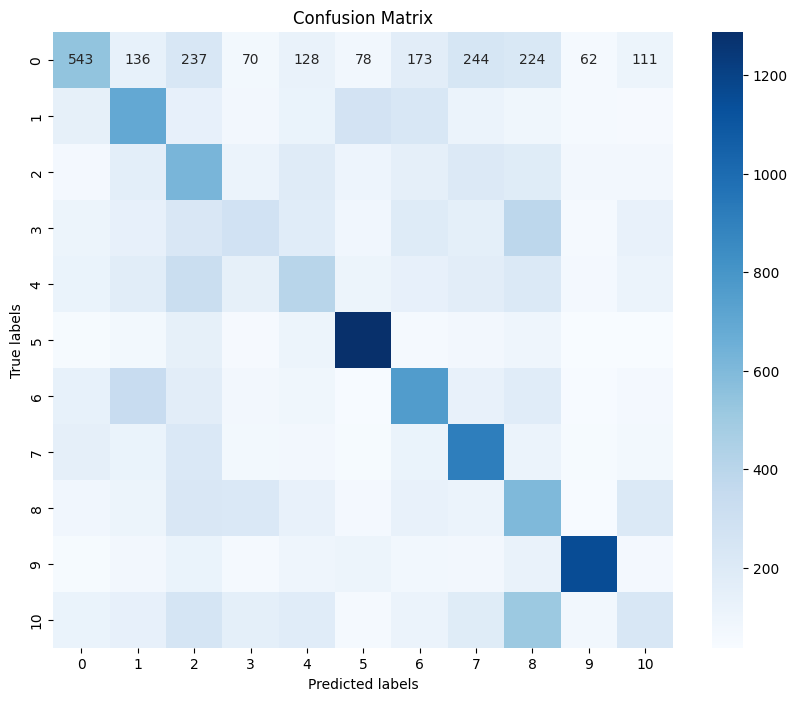

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot confusion matrix as heatmap
plt.figure(figsize=(10, 8))
conf_matrix = confusion_matrix(y_val, y_pred)
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", 
            xticklabels=range(11), yticklabels=range(11))
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

Map together from ideology

In [49]:
# Define a function to map individual labels to broader categories
def map_to_ideology(label):
    if label in [0, 1, 2, 3, 4]:   # Liberal
        return 'Liberal'
    elif label == 5:               # Neutral
        return 'Neutral'
    elif label in [6, 7, 8, 9, 10]: # Conservative
        return 'Conservative'
    else:
        raise ValueError(f"Unexpected label: {label}")

# Apply the mapping to your true labels and predictions
y_val_ideology = np.array([map_to_ideology(label) for label in y_val])
y_pred_ideology = np.array([map_to_ideology(label) for label in y_pred])


In [50]:
# Create a confusion matrix for the mapped labels
conf_matrix_ideology = confusion_matrix(y_val_ideology, y_pred_ideology, labels=['Liberal', 'Neutral', 'Conservative'])

print("Confusion Matrix (Mapped Ideologies):")
print(conf_matrix_ideology)

# Generate a classification report for the mapped labels
class_report_ideology = classification_report(y_val_ideology, y_pred_ideology)

print("Classification Report (Mapped Ideologies):")
print(class_report_ideology)

print("Validation accuracies concatenated")
val_accuracy_conc = np.mean(y_val_ideology == y_pred_ideology)
print(val_accuracy_conc)


Confusion Matrix (Mapped Ideologies):
[[5572  643 3728]
 [ 429 1288  312]
 [3496  330 6202]]
Classification Report (Mapped Ideologies):
              precision    recall  f1-score   support

Conservative       0.61      0.62      0.61     10028
     Liberal       0.59      0.56      0.57      9943
     Neutral       0.57      0.63      0.60      2029

    accuracy                           0.59     22000
   macro avg       0.59      0.60      0.60     22000
weighted avg       0.59      0.59      0.59     22000

Validation accuracies concatenated
0.5937272727272728


# Try With Densely Connected Neural Network

Entire Dataset

In [176]:
np_embedding = np.load("data/uncleaned_data/npy_BiasData_100-per-class-labels_paraphrase-MiniLM-L6-v2.npy")
JerryWeiData = pd.read_csv("data/uncleaned_data/JerryWeiAIData/train_orig.csv")
np_labels = np.array(JerryWeiData["label"])

Reduced Dataset

In [11]:
np_embedding = np.load("data/cleaned_data/npy_BiasData_100-per-class-SentenceEmbedding_paraphrase-MiniLM-L6-v2.npy")
np_labels = np.load("data/cleaned_data/npy_BiasData_100-per-class-labels_paraphrase-MiniLM-L6-v2.npy")

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class NN(nn.Module):
    def __init__(self, in_features):
        super(NN, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(in_features, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.Dropout(0.25),
            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.LeakyReLU(),
            nn.Dropout(0.25),
            nn.Linear(16, 10)  # Output layer with 10 units
        )

    def forward(self, x):
        output = self.classifier(x)
        # Apply softmax activation to get class probabilities
        return F.softmax(output, dim=1)

In [5]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        feature = self.features[idx]
        label = self.labels[idx]
        return feature, label

In [11]:
X_train, X_val, y_train, y_val = train_test_split(np_embedding,
                                                  np_labels,
                                                  test_size=0.2)

In [7]:
#training loop 
epochs = 100 
lr = 0.01 
bs = 8

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate model
model = NN(in_features=X_train.shape[1])
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

y_train_reshaped = y_train.reshape(-1, 1)
y_val_reshaped = y_val.reshape(-1, 1)

train_set = CustomDataset(X_train, y_train_reshaped)
test_set = CustomDataset(X_val, y_val_reshaped)

#train_set = np.concatenate([X_train, y_train_reshaped], axis = 1)
#test_set = np.concatenate([X_val, y_val_reshaped], axis = 1)

train_loader = DataLoader(train_set, batch_size=bs)
test_loader = DataLoader(test_set, batch_size=bs)

In [ ]:
training_accuracies = []
training_losses = []
testing_accuracies = []
testing_losses = []

for epoch in range(epochs):
    model.train()
    
    train_correct = 0
    total_train = 0
    train_loss_sum = 0

    start_time = time.time()

    for idx, (embedding, label) in enumerate(train_loader): 
        embedding, label = embedding.to(device), label.to(device).squeeze()  # Squeeze the label to remove the extra dimension
        y_pred = model(embedding)
        optimizer.zero_grad()

        train_loss = criterion(y_pred, label)
        train_loss_sum += train_loss.item()
        train_loss.backward()
        optimizer.step()

        _, predicted = torch.max(y_pred, dim=1)
        train_correct += (predicted == label).sum().item()
        total_train += label.size(0)
    
    avg_train_loss = train_loss_sum / len(train_loader)
    train_acc = train_correct / total_train
    training_accuracies.append(train_acc)
    training_losses.append(avg_train_loss)

    model.eval()
    test_correct = 0
    total_test = 0
    test_loss_sum = 0
    with torch.no_grad():
        for idx, (embedding, label) in enumerate(test_loader):
            embedding, label = embedding.to(device), label.to(device).squeeze()  # Squeeze the label to remove the extra dimension
            y_pred = model(embedding)
            test_loss = criterion(y_pred, label)
            test_loss_sum += test_loss.item()
            
            _, predicted = torch.max(y_pred, dim=1)
            test_correct += (predicted == label).sum().item()
            total_test += label.size(0)

    avg_test_loss = test_loss_sum / len(test_loader)
    test_acc = test_correct / total_test
    testing_losses.append(avg_test_loss)
    testing_accuracies.append(test_acc)

    print(f"Epoch: {epoch+1}/{epochs}, Time per Epoch: {time.time() - start_time:.2f}s, "
          f"Training Accuracy: {train_acc:.4f}, Testing Accuracy: {test_acc:.4f}, "
          f"Training Loss: {avg_train_loss:.4f}, Testing Loss: {avg_test_loss:.4f}")

# Visualize Word Embeddings - Slisemap, TSNE & PCA

PCA Analysis

In [109]:
np_embedding = np.load("data/cleaned_data/npy_BiasData_100-per-class-SentenceEmbedding_paraphrase-MiniLM-L6-v2.npy")
np_labels = np.load("data/cleaned_data/npy_BiasData_100-per-class-labels_paraphrase-MiniLM-L6-v2.npy")

In [61]:
from sklearn.decomposition import PCA
pca = PCA(n_components=50)
pca.fit(np_embedding)
pca_embedding = pca.transform(np_embedding)

In [63]:
from sklearn.manifold import TSNE

embeddings = pca_embedding
labels = np_labels
# Step 3: Apply T-SNE
# Initialize T-SNE with desired parameters
# n_iter = 1000 & perplecity = 30 --> Bad result 
tsne = TSNE(n_components=2, perplexity=20, n_iter=5000, random_state=42)

# Reduce dimensionality
tsne_results = tsne.fit_transform(embeddings)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f1decd6b400>
Traceback (most recent call last):
  File "/home/carlviggo/anaconda3/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/carlviggo/anaconda3/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/carlviggo/anaconda3/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/carlviggo/anaconda3/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


Ide! Extrahera signifikanta ord, och undersök sedan om de förekommer. Om man vill ha mer djupgående analys, skapa word-embeddings


Try with Slisemap instead of TSNE

In [111]:
import numpy as np
from slisemap import Slisemap
import matplotlib.pyplot as plt
from xgboost import XGBClassifier

#np_embedding = np.load("data/cleaned_data/npy_BiasData_10000_sentence_embedding_BERT.npy")
#np_labels = np.load("data/cleaned_data/npy_BiasData_10000_labels_BERT.npy")
model = XGBClassifier()
model.load_model('models/xgb_rf_gpu_model_all_data.json')

X = np_embedding
y = model.predict(X)

In [113]:
sm = Slisemap(X, y, lasso=0.01, random_state=42, device = )
# Optimise the solution
%time sm.optimise()

CPU times: user 2min 46s, sys: 26.5 s, total: 3min 13s
Wall time: 3min 12s


807.0769653320312

In [121]:
clusters = sm.get_model_clusters(11)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f1debc740d0>
Traceback (most recent call last):
  File "/home/carlviggo/anaconda3/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/carlviggo/anaconda3/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/carlviggo/anaconda3/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/carlviggo/anaconda3/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f1debc740d0>
Traceback (most recent call last):
  File "/home/carlviggo/anaconda3/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/carlviggo/anaconda3/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/carlviggo/anaconda3/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/carlviggo/anaconda3/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_p

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f1debfd93f0>
Traceback (most recent call last):
  File "/home/carlviggo/anaconda3/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/carlviggo/anaconda3/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/carlviggo/anaconda3/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/carlviggo/anaconda3/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_p

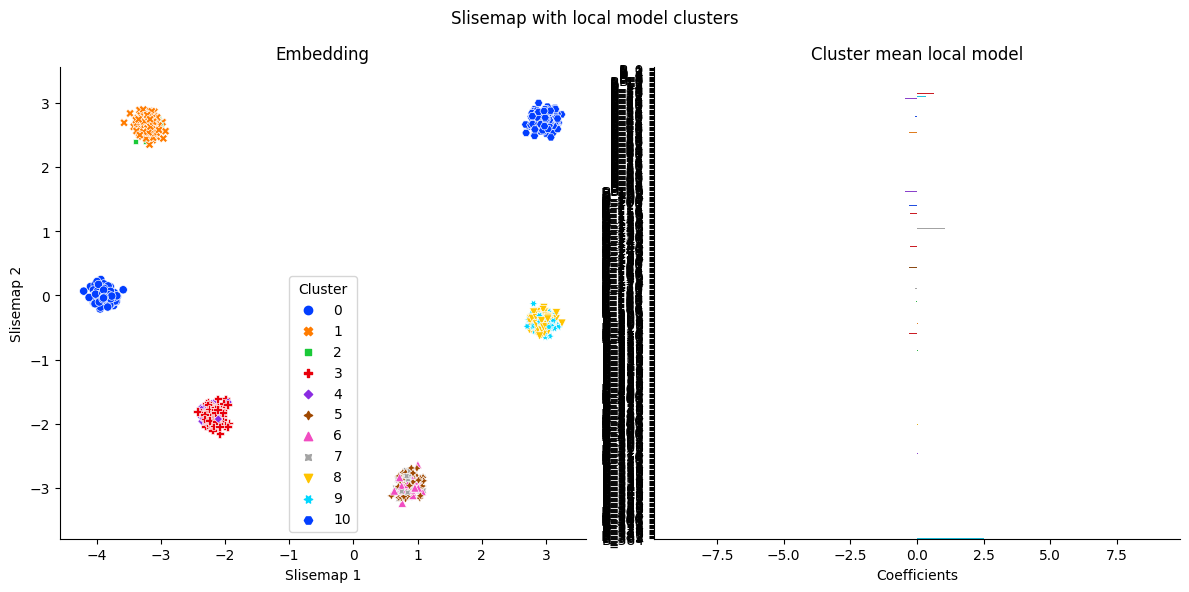

In [114]:
clusters = 11
sm.plot(
    title="Slisemap with local model clusters",
    clusters=clusters,
    jitter=0.1,
)

Example from Internet


In [94]:
JerryWeiData = pd.read_csv("data/uncleaned_data/JerryWeiAIData/train_orig.csv")

In [95]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Sample data
data = {
    'text': [
        "This product is amazing and works like a charm.",
        "I had a terrible experience with this product.",
        "The service was fantastic, will come again!",
        "Very disappointed with the quality of the product.",
        # Add more samples
    ],
    'label': [0, 1, 0, 1]  # 0: Non-biased, 1: Biased
}


# Split the data
X_train, X_test, y_train, y_test = train_test_split(JerryWeiData['text'], JerryWeiData['label'], test_size=0.2, random_state=42)

# TF-IDF Vectorizer
vectorizer = TfidfVectorizer(stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Logistic Regression Model
model = LogisticRegression()
model.fit(X_train_tfidf, y_train)

# Predictions
y_pred = model.predict(X_test_tfidf)

# Evaluation
print(classification_report(y_test, y_pred))

# Detecting bias in new text
new_text = ["The food was awful and the staff were rude."]
new_text_tfidf = vectorizer.transform(new_text)
bias_prediction = model.predict(new_text_tfidf)
print("Bias detected" if bias_prediction[0] == 1 else "No bias detected")


              precision    recall  f1-score   support

           0       0.37      0.35      0.36      4476
           1       0.29      0.32      0.30      4685
           2       0.27      0.28      0.27      4628
           3       0.25      0.28      0.26      4528
           4       0.22      0.22      0.22      4617
           5       0.36      0.34      0.35      4597
           6       0.32      0.30      0.31      4508
           7       0.36      0.38      0.37      4720
           8       0.24      0.24      0.24      4702
           9       0.40      0.47      0.43      4707
          10       0.25      0.18      0.21      4589

    accuracy                           0.31     50757
   macro avg       0.30      0.30      0.30     50757
weighted avg       0.30      0.31      0.30     50757

No bias detected


/home/carlviggo/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [99]:
new_text = ["The food  was awful and the staff were rude."]
new_text_tfidf = vectorizer.transform(new_text)
bias_prediction = model.predict(new_text_tfidf)
print("Bias detected" if bias_prediction[0] == 1 else "No bias detected")

No bias detected


In [ ]:
# Monday Todo
        # Create new, binary dataset (df.drop(row/s)) YES! 
        # Create new Pytorch classifier from scratch
        # Look through all code, clean code  YES! 
        # Prepare to run code with new dataset  YES! 

# Create Binary Dataset: 

In [125]:
labels_to_binarise = np.load("data/cleaned_data/npy_Binary_BiasData_100_labels_BERT.npy")
labels_to_binarise = pd.DataFrame(labels_to_binarise)

In [126]:
import pandas as pd
labels_to_binarise = labels_to_binarise.replace([0,1,2,3,4], 0)
labels_to_binarise = labels_to_binarise[labels_to_binarise != 5]
labels_to_binarise = labels_to_binarise.replace([6,7,8,9,10], 1)
labels_to_binarise = np.array(labels_to_binarise)
labels_to_binarise = labels_to_binarise[~np.isnan(labels_to_binarise)]
np.save("data/cleaned_data/npy_Binary_BiasData_100_labels_BERT.npy", labels_to_binarise)

In [6]:
JerryWeiData.shape

(230710, 2)

Logistic Ridge Regression

In [158]:
# load reduced dataset for testing purposes
labels = np.load("data/cleaned_data/npy_Binary_BiasData_100_labels_BERT.npy")
embeddings = np.load("data/cleaned_data/npy_Binary_BiasData_100_sentence_embedding_BERT.npy")

In [160]:
X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, test_size = 0.2, random_state = 69)

In [161]:
X_train.shape

(800, 768)

In [162]:
from sklearn.linear_model import LogisticRegression 
model = LogisticRegression(solver='liblinear', C=1.0) 
model.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

Model Evaluation

In [163]:
y_pred = model.predict(X_test)

model_score = model.score(X = X_test, y = y_pred)

print("Model score: {model_score}")

correct = 0
for idx in range(len(y_pred)): 
    if y_pred[idx] == y_test[idx]: 
        correct += 1

print(f"Validation accuracy: {(correct / len(y_pred)) * 100}%")

#classification_report = classification_report(y_true = y_test, y_pred=y_pred)

#print(f"Classification report: {classification_report}")

Model score: {model_score}
Validation accuracy: 63.0%


Model probabilities

In [164]:
# Determine which column that belongs to which class
y_pred_proba = model.predict_proba(X_test)

In [165]:
df = pd.DataFrame(y_pred_proba)

In [168]:
df.head(n=20)

,0,1
0,0.205359,0.794641
1,0.383980,0.616020
2,0.371168,0.628832
3,0.464457,0.535543
4,0.433872,0.566128
5,0.414268,0.585732
6,0.444964,0.555036
7,0.320018,0.679982
8,0.620162,0.379838
9,0.466381,0.533619


In [167]:
y_test

array([1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1.,
       1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0.,
       0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 0.,
       0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0., 1.,
       0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 1., 1.,
       1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1.,
       1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.,
       0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0.])

Create some kind of 1 dimensional plot

Test Preimported Classifier

In [169]:
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from transformers import pipeline
tokenizer = AutoTokenizer.from_pretrained("d4data/bias-detection-model")
model = TFAutoModelForSequenceClassification.from_pretrained("d4data/bias-detection-model")

classifier = pipeline('text-classification', model=model, tokenizer=tokenizer) # cuda = 0,1 based on gpu availability
classifier("The irony, of course, is that the exhibit that invites people to throw trash at vacuuming Ivanka Trump lookalike reflects every stereotype feminists claim to stand against, oversexualizing Ivanka’s body and ignoring her hard work.")

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

/home/carlviggo/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/657 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

ImportError: 
TFAutoModelForSequenceClassification requires the TensorFlow library but it was not found in your environment.
However, we were able to find a PyTorch installation. PyTorch classes do not begin
with "TF", but are otherwise identically named to our TF classes.
If you want to use PyTorch, please use those classes instead!

If you really do want to use TensorFlow, please follow the instructions on the
installation page https://www.tensorflow.org/install that match your environment.


In [175]:
pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.7 MB/s eta 0:00:0000:0100:06
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 2.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 1.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 3.1 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 1.2 MB/s eta 0:00:0000:0100:010m
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 1.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 1.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 1.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 993.4 kB/s eta 0:00:00 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 961.9 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 744.6 kB/s 

In [178]:
pip install tf-keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 2.2 MB/s eta 0:00:0000:0100:010m
Note: you may need to restart the kernel to use updated packages.


In [183]:
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from transformers import pipeline
tokenizer = AutoTokenizer.from_pretrained("d4data/bias-detection-model")
model = TFAutoModelForSequenceClassification.from_pretrained("d4data/bias-detection-model")

classifier = pipeline('text-classification', model=model, tokenizer=tokenizer) # cuda = 0,1 based on gpu availability
classifier("The irony, of course, is that the exhibit that invites people to throw trash at vacuuming Ivanka Trump lookalike reflects every stereotype feminists claim to stand against, oversexualizing Ivanka’s body and ignoring her hard work.")

ImportError: 
TFAutoModelForSequenceClassification requires the TensorFlow library but it was not found in your environment.
However, we were able to find a PyTorch installation. PyTorch classes do not begin
with "TF", but are otherwise identically named to our TF classes.
If you want to use PyTorch, please use those classes instead!

If you really do want to use TensorFlow, please follow the instructions on the
installation page https://www.tensorflow.org/install that match your environment.


# Try this one out, this should be ideal

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("premsa/political-bias-prediction-allsides-DeBERTa")
tokenizer = AutoTokenizer.from_pretrained("premsa/political-bias-prediction-allsides-DeBERTa")
nlp = pipeline("text-classification", model=model, tokenizer=tokenizer)
print(nlp("the masses are controlled by media."))

# Test improved Bias model

0 = left, 2 = right, 1 = center. 

In [92]:
from transformers import pipeline, AutoModelForSequenceClassification, AutoTokenizer

model = AutoModelForSequenceClassification.from_pretrained("premsa/political-bias-prediction-allsides-DeBERTa")
tokenizer = AutoTokenizer.from_pretrained("premsa/political-bias-prediction-allsides-DeBERTa")
nlp = pipeline("text-classification", model=model, tokenizer=tokenizer)
prediction = nlp("Vice President Kamala Harris can legitimately be described as the party bosses’ candidate. She has never won a delegate. Even in her 2020 race, she dropped out early. She has no grassroots appeal. She’s attractive only to the elites, who feel she is useful in defeating Trump. ")

# translate to correct label
if prediction[0]["label"] == "LABEL_2": 
    prediction[0]["label"] = "right"
elif prediction[0]["label"] == "LABEL_1": 
    prediction[0]["label"] = "center"
elif prediction[0]["label"] == "LABEL_0": 
    prediction[0]["label"] = "left"

In [93]:
prediction

[{'label': 'right', 'score': 0.9619806408882141}]

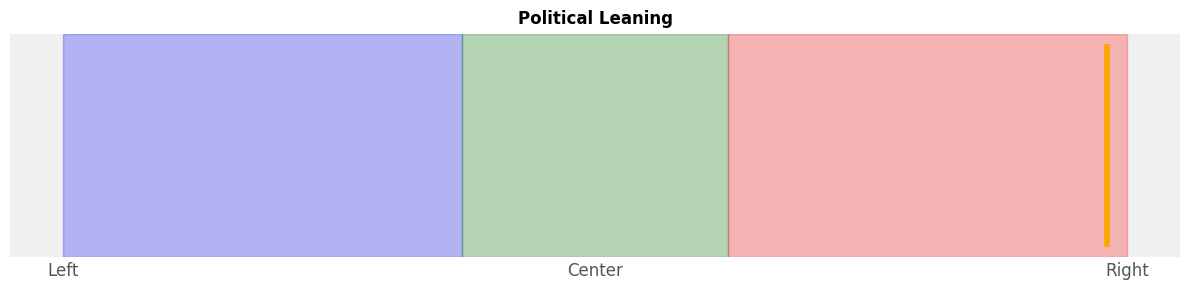

In [91]:
import matplotlib.pyplot as plt
import numpy as np

# Example probabilities for left, center, and right
data = prediction

# Define the positions for left, center, and right on the x-axis
positions = {
    'left': -1,
    'center': 0,
    'right': 1
}

# Calculate the x positions based on probabilities
x = []
y = []
for item in data:
    if item['label'] == 'left':
        x.append(-item['score'])
    elif item['label'] == 'center':
        x.append(item['score'] - 0.5)
    elif item['label'] == 'right':
        x.append(item['score'])
    y.append(0)  # y position is always 0 for a horizontal line

# Create the plot
plt.figure(figsize=(12, 3))

# Add background color gradients
plt.axvspan(-1, -0.25, color='blue', alpha=0.25)
plt.axvspan(-0.25, 0.25, color='green', alpha=0.25)
plt.axvspan(0.25, 1, color='red', alpha=0.25)

# Add lines for each data point
for i, xi in enumerate(x):
    plt.vlines(xi, ymin=-0.1, ymax=0.1, colors='orange', linewidth=4)

# Set the x-ticks and labels
plt.xticks([-1, -0.5, 0, 0.5, 1], ['Left', '', 'Center', '', 'Right'], fontsize=12)
plt.gca().tick_params(axis='x', length=0)  # Remove tick lines on the x-axis
plt.yticks([])  # Hide y-axis

# Improve font styles and add subtle background gradient
#plt.xlabel('Political Leaning', fontsize=12, fontweight='bold')
plt.title('Political Leaning', fontsize=12, fontweight='bold', pad=7)

# Enhance the appearance
plt.gca().set_facecolor('#f0f0f0')  # Light grey background
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().tick_params(axis='x', colors='#555555')

# Show the plot
plt.tight_layout()
plt.show()

# Benchmark model on held out dataset

In [100]:
from unicodeescape_to_ubuntu import uni_to_ubuntu

In [101]:
held_out_data = pd.read_csv(uni_to_ubuntu("C:/Users/Johan/Documents/ITligence/data/cleaned_data/binary_JerryWeiData.csv"))

In [131]:
# 0 = liberal
# 1 = conservative

left_held_out = held_out_data[held_out_data["label"] == 0].iloc[:,1:]
right_held_out = held_out_data[held_out_data["label"] == 1].iloc[:,1:]

In [158]:
held_out_data_full = pd.read_csv(uni_to_ubuntu("C:\Users\Johan\Documents\ITligence\data\uncleaned_data\JerryWeiAIData\train_orig.csv"))

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (676879147.py, line 1)

In [140]:
right_held_out.columns

Index(['label', 'text'], dtype='object')

In [160]:
def compute_label(data): 
    model = AutoModelForSequenceClassification.from_pretrained("premsa/political-bias-prediction-allsides-DeBERTa")
    tokenizer = AutoTokenizer.from_pretrained("premsa/political-bias-prediction-allsides-DeBERTa")
    nlp = pipeline("text-classification", model=model, tokenizer=tokenizer)
    prediction = nlp(data) 

    # translate to same labels as in dataset
    if prediction[0]["label"] == "LABEL_2": 
        prediction[0]["label"] = 1
    elif prediction[0]["label"] == "LABEL_1": 
        prediction[0]["label"] = "center"
    elif prediction[0]["label"] == "LABEL_0": 
        prediction[0]["label"] = 0
    
    return prediction

In [189]:
test = compute_label("I hate jews and immigrants")

test

In [190]:
test

[{'label': 0, 'score': 0.5250459909439087}]

In [161]:
prediction_right = right_held_out["text"][0:3].map(compute_label)

In [162]:
prediction_left = left_held_out["text"][0:3].map(compute_label)

Test on just NYT & FOX 

In [169]:
full_data = pd.read_csv("/mnt/c/Users/Johan/Documents/ITligence/data/uncleaned_data/JerryWeiAIData/train_orig.csv")

In [228]:
list = np.random.randint(10,20, size=(10)).tolist()
print(len(list))
print(list)

10
[16, 15, 17, 19, 13, 10, 18, 19, 12, 18]


In [229]:
for i in range(len(list)-1): 
    for j in range(len(list)): 
        if list[i] < list[j]: 
            list[i] = list[j]
            list[j] = list[i]

In [230]:
print(list)

[19, 19, 19, 19, 19, 19, 19, 19, 19, 18]


In [175]:
NYT_data = full_data[full_data["label"] == 1]
WP_data = full_data[full_data["label"] == 6]

In [178]:
prediction_NYT = NYT_data["text"][0:7].map(compute_label)

In [179]:
prediction_WP = WP_data["text"][0:7].map(compute_label)

In [180]:
prediction_NYT

23071     [{'label': 0, 'score': 0.4625384211540222}]
23072     [{'label': 0, 'score': 0.6026450395584106}]
23073     [{'label': 0, 'score': 0.5595487356185913}]
23074     [{'label': 0, 'score': 0.3942570984363556}]
23075     [{'label': 0, 'score': 0.5169384479522705}]
23076     [{'label': 1, 'score': 0.5505874752998352}]
23077    [{'label': 0, 'score': 0.46213847398757935}]
Name: text, dtype: object

In [181]:
prediction_WP

138426      [{'label': 0, 'score': 0.502722978591919}]
138427     [{'label': 0, 'score': 0.7463482618331909}]
138428    [{'label': 0, 'score': 0.46587109565734863}]
138429     [{'label': 0, 'score': 0.7060700058937073}]
138430     [{'label': 0, 'score': 0.5652218461036682}]
138431    [{'label': 0, 'score': 0.44670242071151733}]
138432     [{'label': 0, 'score': 0.4583081305027008}]
Name: text, dtype: object